## 3.1 Autoencoder

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (validation_images, validation_labels) = fashion_mnist.load_data()

In [ ]:
#@title Funciones auxiliares
def normalizar(dataset):
  return (dataset - train_images.mean()) / train_images.std()

def show_images(images, labels=None, image_count=25, random=True):
  plt.figure(figsize=(10,10))
  cant_subplot = np.sqrt(image_count)
  cant_subplot_int = int(cant_subplot)

  if(cant_subplot_int != cant_subplot):
    print("image_count no es un numero con raiz entera, se va a recortar el numero de imagenes") 

  for i in range(image_count):
    plt.subplot(cant_subplot,cant_subplot,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_index = i
    if random:
      img_index = np.random.randint(0, images.shape[0])
    plt.imshow(images[img_index], cmap="gray_r")
    if labels is not None:
      plt.xlabel(labels[img_index])

def ecm(original, prediccion):
  return ((original-prediccion)**2).mean()


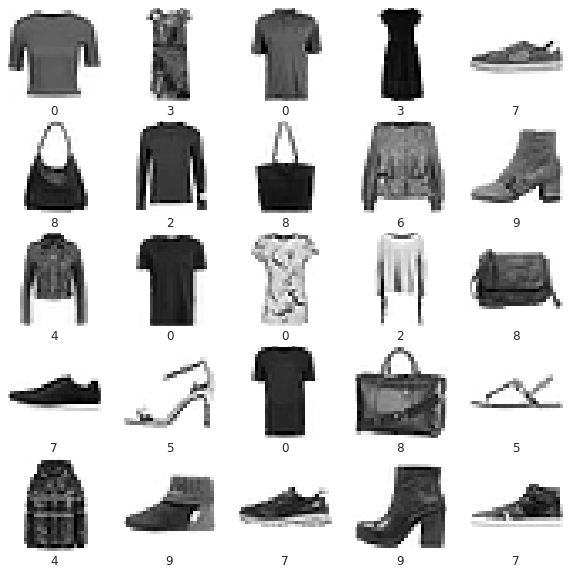

In [ ]:
show_images(train_images, train_labels)

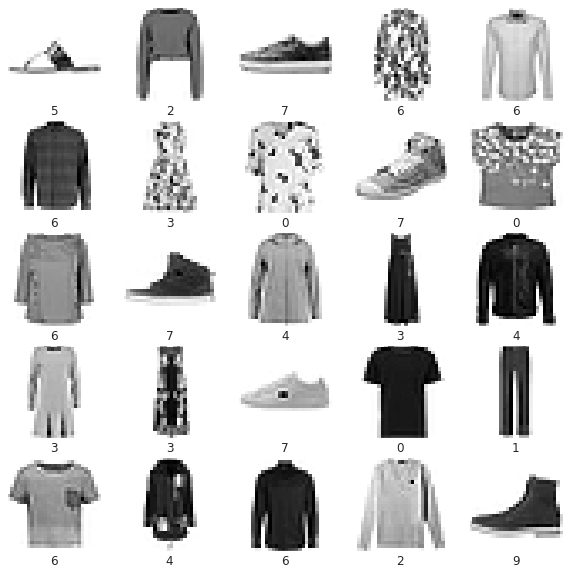

In [ ]:
train_images_normalizado = normalizar(train_images)
validation_images_normalizado = normalizar(validation_images)

shape_original = train_images.shape[1:]
dx = shape_original[0]*shape_original[1]

show_images(train_images_normalizado, labels=train_labels)

In [ ]:
batch_size = 512
epochs = 200
n_hidden_units = 128

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=shape_original))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(n_hidden_units, activation='relu', kernel_initializer='GlorotNormal'))
model.add(tf.keras.layers.Dropout(0.2, name="encode"))
model.add(tf.keras.layers.Dense(dx, kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Reshape(shape_original))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               100480    
                                                                 
 encode (Dropout)            (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 784)               101136    
                                                                 
 reshape_15 (Reshape)        (None, 28, 28)            0         
                                                                 
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Mejor performance:
#   batch_size = 512
#   epochs = 200
#   n_hidden_layers = 128
#   lr_inicial = 40.0
#   decay_rate = 0.6 

lr_inicial = 40.0
decay_rate = 0.6

def step_decay(epoch):
  if epoch < 10:
    return lr_inicial*np.exp(-decay_rate*epoch)
  else:
    return lr_inicial*np.exp(-decay_rate*epoch)+np.exp(-1)

# lr = tf.keras.callbacks.LearningRateScheduler(step_decay)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam() ,loss=tf.keras.losses.MeanSquaredError())
hist = model.fit(x=train_images_normalizado, y=train_images_normalizado, batch_size = batch_size, epochs=epochs, callbacks=[es], validation_data=(validation_images_normalizado, validation_images_normalizado))

Epoch 1/200
118/118 [==============================] - 4s 29ms/step - loss: 0.7695 - val_loss: 0.4105
Epoch 2/200
118/118 [==============================] - 2s 19ms/step - loss: 0.3900 - val_loss: 0.2686
Epoch 3/200
118/118 [==============================] - 2s 19ms/step - loss: 0.3148 - val_loss: 0.2352
Epoch 4/200
118/118 [==============================] - 3s 21ms/step - loss: 0.2931 - val_loss: 0.2193
Epoch 5/200
118/118 [==============================] - 3s 24ms/step - loss: 0.2803 - val_loss: 0.2077
Epoch 6/200
118/118 [==============================] - 2s 19ms/step - loss: 0.2690 - val_loss: 0.1979
Epoch 7/200
118/118 [==============================] - 2s 19ms/step - loss: 0.2597 - val_loss: 0.1938
Epoch 8/200
118/118 [==============================] - 2s 19ms/step - loss: 0.2553 - val_loss: 0.1917
Epoch 9/200
118/118 [==============================] - 2s 19ms/step - loss: 0.2532 - val_loss: 0.1870
Epoch 10/200
118/118 [==============================] - 2s 19ms/step - loss: 0.250

In [ ]:
validation_images_normalizado_pred = model.predict(validation_images_normalizado)
ecm(validation_images_normalizado, validation_images_normalizado_pred)

0.1657856482617419

In [ ]:
model.save('autoencoder.h5')

### Detector de anomalias

In [ ]:
mnist = tf.keras.datasets.mnist
(number_images, number_labels), (number_validation_images, number_validation_labels) = mnist.load_data()

In [ ]:
#@title Funciones auxiliares
def ec(original, prediccion):
  tamano_por_img = original.shape[1]*original.shape[2]
  return np.sum((original-prediccion)**2, axis=(1,2))/tamano_por_img

def rates(dataset, prediccion, step = 0.01, umbral_start=None, umbral_stop=None):
  EC = ec(dataset, prediccion)

  if umbral_start is None:
    umbral_start = int(np.floor(EC.min()))

  if umbral_start is None:
    umbral_stop = int(np.ceil(EC.max()))

  mask = np.full((20000), False)
  mask[:10000] = True

  size = int(np.ceil((umbral_stop-umbral_start) // step))
  TP = np.zeros((size))
  FP = np.zeros((size))
  umbrales = np.zeros((size))

  for i in range(0, size):
    umbral = i*step + umbral_start
    TP[i] = dataset[(EC <= umbral) & mask].shape[0]
    FP[i] = dataset[(EC <= umbral) & (np.logical_not(mask))].shape[0]
    umbrales[i] = umbral

  TPR = TP / 10000
  FPR = FP / 10000

  return TPR, FPR, umbrales


In [ ]:
number_validation_images_normalizado = normalizar(number_validation_images)

In [ ]:
dataset_mezclado = np.concatenate((validation_images_normalizado, number_validation_images_normalizado), axis=0)

dataset_mezclado.shape

(20000, 28, 28)

In [ ]:
y_mezclado_pred = model.predict(dataset_mezclado)
error_cuadratico = ec(y_mezclado_pred, dataset_mezclado)

In [ ]:
error_cuadratico[:10000].mean(), error_cuadratico[10000:].mean()

(0.1657856482617421, 0.4666525491951148)

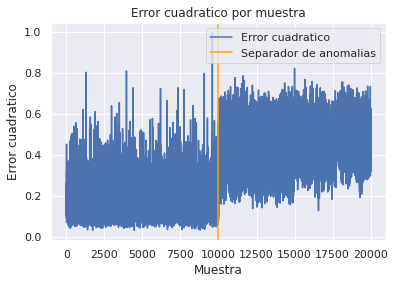

In [ ]:
plt.plot(error_cuadratico, label="Error cuadratico")
plt.ylabel("Error cuadratico")
plt.xlabel("Muestra")
plt.axvline(x=10000, c="orange", label="Separador de anomalias")
plt.legend(loc="best")
plt.title("Error cuadratico por muestra")
plt.show()

In [ ]:
TPR, FPR, umbrales = rates(dataset_mezclado, y_mezclado_pred, step=0.01, umbral_start=0, umbral_stop=1)
FNR = 1 - TPR

k = np.argmin((FPR-FNR)**2)
EER = FPR[k]
umbral = umbrales[k]

Equal Error Rate: 0.0763
Umbral para alcanzar el Equal Error Rate: 0.29


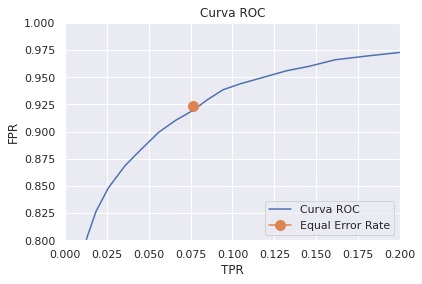

In [ ]:
escala = 0.2

plt.xlim((0,escala))
plt.ylim((1-escala,1))

plt.plot(FPR, TPR, label="Curva ROC")
plt.plot(EER, 1-EER, marker="o", markersize=10, label="Equal Error Rate")

plt.xlabel("TPR")
plt.ylabel("FPR")
plt.legend(loc='lower right')
plt.title("Curva ROC")

print(f"Equal Error Rate: {EER}")
print(f"Umbral para alcanzar el Equal Error Rate: {umbral}")

plt.show()

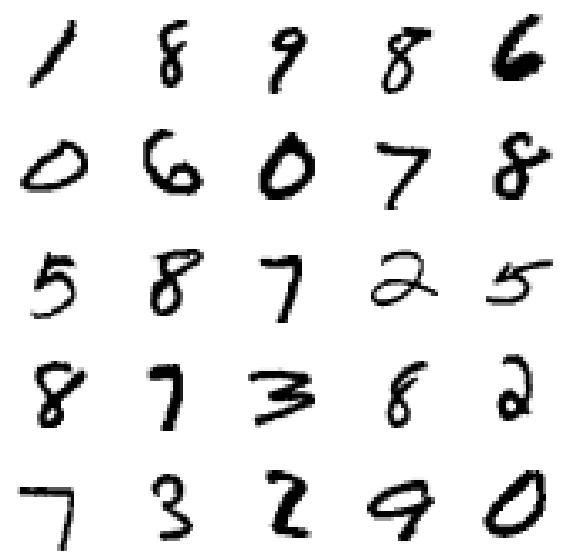

In [ ]:
anomalias = dataset_mezclado[error_cuadratico > umbral]
show_images(anomalias)

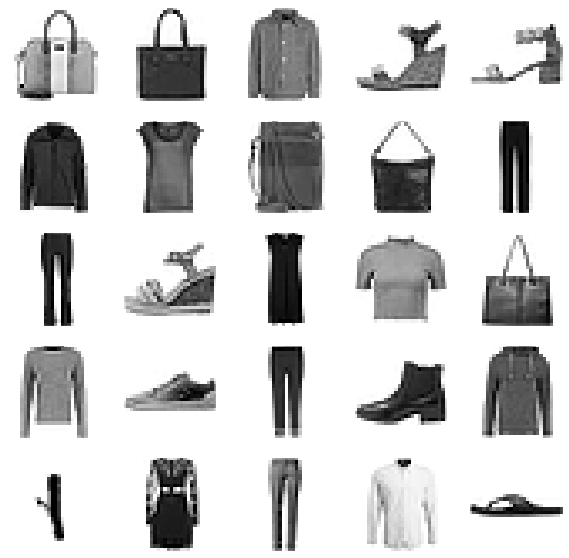

In [ ]:
anomaliasnt = dataset_mezclado[error_cuadratico <= umbral]
show_images(anomaliasnt)

### Obtencion de unidades de menor dimension

In [ ]:
extractor = tf.keras.Model(inputs=model.inputs,
                        outputs=model.get_layer("encode").output)

U_train_images = np.array(extractor(train_images_normalizado))
U_validation_images = np.array(extractor(validation_images_normalizado))
U_train_images.shape, U_validation_images.shape

((60000, 128), (10000, 128))

In [ ]:
U_fashion_mnist_dataset = np.concatenate((U_train_images, U_validation_images), axis=0)
U_fashion_mnist_dataset.shape

(70000, 128)

In [ ]:
np.save("./fashion_mnist_encoded", U_fashion_mnist_dataset)

## 3.2 Clasificacion

In [52]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (validation_images, validation_labels) = cifar10.load_data()

In [80]:
#@title Funciones auxiliares
def normalizar(dataset):
  suma = dataset.sum(axis=3).astype(float)
  res = dataset.copy().astype(float)
  suma[suma == 0] = 1
  res[:,:,:,0] = (dataset[:,:,:,0] / suma)
  res[:,:,:,1] = (dataset[:,:,:,1] / suma)
  res[:,:,:,2] = (dataset[:,:,:,2] / suma)
  return res
  # return (dataset - train_images.mean()) / train_images.std()

def show_images(images, labels=None, image_count=25, random=True):
  plt.figure(figsize=(10,10))
  cant_subplot = np.sqrt(image_count)
  cant_subplot_int = int(cant_subplot)

  if(cant_subplot_int != cant_subplot):
    print("image_count no es un numero con raiz entera, se va a recortar el numero de imagenes") 

  for i in range(image_count):
    plt.subplot(cant_subplot,cant_subplot,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_index = i
    if random:
      img_index = np.random.randint(0, images.shape[0])
    plt.imshow(images[img_index], cmap="gray_r")
    if labels is not None:
      plt.xlabel(labels[img_index])

def ecm(original, prediccion):
  return ((original-prediccion)**2).mean()


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


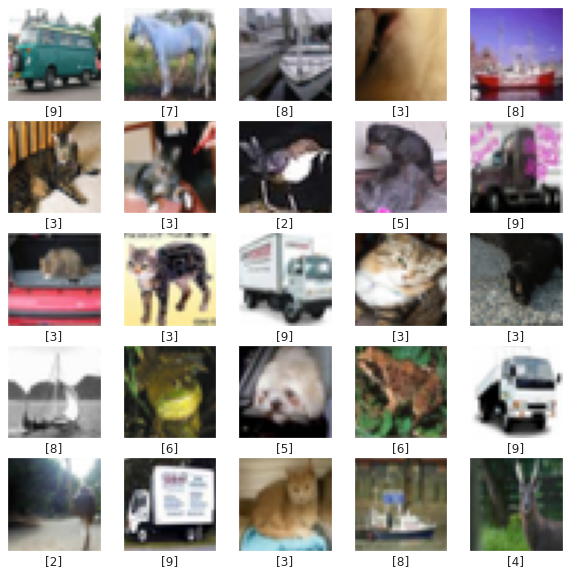

In [5]:
show_images(train_images, labels=train_labels)

In [67]:
train_images_normalizado.shape

(50000, 32, 32, 3)

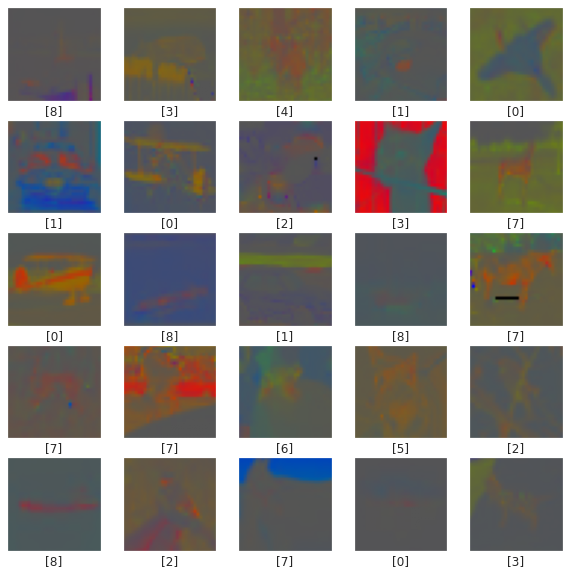

In [82]:
train_images_normalizado = normalizar(train_images)
validation_images_normalizado = normalizar(validation_images)

shape_original = train_images.shape[1:]
dx = shape_original[0]*shape_original[1]*shape_original[2]

show_images(train_images_normalizado, labels=train_labels)

In [177]:
batch_size = 128
epochs = 30
n_hidden_units = 256
n_clases = len(np.unique(train_labels))

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=shape_original))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(n_hidden_units, activation='sigmoid', kernel_initializer='GlorotNormal'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(n_hidden_units, activation='relu', kernel_initializer='HeNormal'))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(n_hidden_units/2, activation='relu', kernel_initializer='GlorotNormal'))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (None, 3072)              0         
                                                                 
 dense_119 (Dense)           (None, 256)               786688    
                                                                 
 dropout_52 (Dropout)        (None, 256)               0         
                                                                 
 dense_120 (Dense)           (None, 256)               65792     
                                                                 
 dense_121 (Dense)           (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________


In [178]:
model.compile(optimizer=tf.keras.optimizers.Adam() ,loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(x=train_images_normalizado, y=train_labels, batch_size = batch_size, epochs=epochs, validation_data=(validation_images_normalizado, validation_labels))

Epoch 1/30
391/391 [==============================] - 7s 16ms/step - loss: 2.1338 - accuracy: 0.1958 - val_loss: 2.0435 - val_accuracy: 0.2448
Epoch 2/30
391/391 [==============================] - 6s 15ms/step - loss: 1.9994 - accuracy: 0.2614 - val_loss: 1.9444 - val_accuracy: 0.2839
Epoch 3/30
391/391 [==============================] - 6s 15ms/step - loss: 1.9367 - accuracy: 0.2890 - val_loss: 1.8626 - val_accuracy: 0.3149
Epoch 4/30
391/391 [==============================] - 6s 15ms/step - loss: 1.9002 - accuracy: 0.3027 - val_loss: 1.8617 - val_accuracy: 0.3229
Epoch 5/30
391/391 [==============================] - 6s 15ms/step - loss: 1.8719 - accuracy: 0.3141 - val_loss: 1.8304 - val_accuracy: 0.3295
Epoch 6/30
391/391 [==============================] - 6s 15ms/step - loss: 1.8579 - accuracy: 0.3199 - val_loss: 1.8102 - val_accuracy: 0.3425
Epoch 7/30
391/391 [==============================] - 6s 15ms/step - loss: 1.8407 - accuracy: 0.3253 - val_loss: 1.7988 - val_accuracy: 0.3454

In [237]:
val_losses = hist.history['val_loss']
val_accuracies = hist.history['val_accuracy']

losses = hist.history['loss']
accuracies = hist.history['accuracy']

print(f"El riesgo empirico final en validacion es {val_losses[-1]}")
print(f"La accuracy final en validacion es {val_accuracies[-1]}")

El riesgo empirico final en validacion es 1.648235559463501
La accuracy final en validacion es 0.4115000069141388


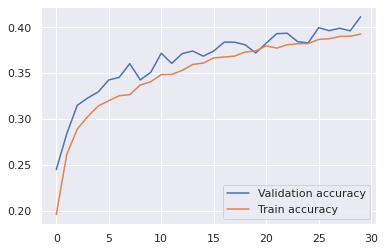

In [243]:
plt.plot(val_accuracies, label="Validation accuracy")
plt.plot(accuracies, label="Train accuracy")
plt.legend(loc="lower right")
plt.show()

## 3.3 Regresion

In [341]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib import request

url="https://raw.githubusercontent.com/CSC-CONICET/CURSO-LEARNING1/main/datasets/molinos.csv"

f = request.urlopen(url)
dataset = pd.read_csv(f)

In [342]:
#@title Funciones auxiliares
def normalizar(dataset, dataset_train):
  return (dataset - dataset_train.mean()) / dataset_train.std()

def ecm(original, prediccion):
  return ((original-prediccion)**2).mean()

def split(dataset, porcentaje):
  n = len(dataset)
  msk = np.random.rand(n) < porcentaje
  return (dataset[msk].iloc[:,:-2], dataset[msk].iloc[:,-2:]), (dataset[~msk].iloc[:,:-2], dataset[~msk].iloc[:,-2:])

In [343]:
dataset.head()

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,P_36,P_37,P_38,P_39,P_40,P_41,P_42,P_43,Velocity,Direction
0,1324.1,1324.3,1330.0,1337.8,1338.1,1328.2,1229.8,1325.6,1256.1,1338.2,...,1296.6,1114.5,1238.1,1316.0,1299.9,1257.5,1138.4,1172.8,12.1,260.0
1,1497.4,1499.0,1499.1,1485.8,1435.6,1338.4,1273.5,1035.2,594.9,1495.0,...,1472.1,1395.8,1289.7,1416.0,1249.6,1114.5,802.1,679.2,10.8,254.0
2,1724.9,1750.3,1467.2,1317.3,1285.5,1178.1,989.0,798.8,376.6,1388.3,...,1370.0,1090.9,962.2,1148.0,1055.2,772.5,555.4,316.3,8.4,253.0
3,1594.7,1686.5,1394.2,1327.2,1247.6,1236.1,1170.3,889.0,255.9,1555.4,...,1185.4,1053.1,773.2,924.2,799.5,576.3,448.1,418.8,7.8,251.0
4,1645.4,1678.3,1537.7,1397.1,1403.9,1390.1,1278.6,654.6,181.3,1624.8,...,1335.1,1504.6,1014.5,1207.9,989.8,1030.7,906.8,816.2,7.8,248.0


In [344]:
dataset_curado = dataset[(dataset.iloc[:,:-2] >= 0).any(axis=1)]
dataset_curado.shape

(123710, 45)

In [345]:
# 0, 1 -> 0, -1
# 90, 1 -> -1, 0
# 180, 1 -> 0, 1
# 270, 1 -> 1, 0
# (-sin(x), -cos(x))

velocidad_x = dataset_curado['Velocity']*dataset_curado['Direction'].map(lambda x: -np.sin(np.pi*x/180))
velocidad_y = dataset_curado['Velocity']*dataset_curado['Direction'].map(lambda x: -np.cos(np.pi*x/180))

dataset_velocidad_cartesiana = dataset_curado.iloc[:,:-2].copy()

dataset_velocidad_cartesiana['Velocity X'] = velocidad_x
dataset_velocidad_cartesiana['Velocity Y'] = velocidad_y

In [346]:
dataset_velocidad_cartesiana.head()

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,P_36,P_37,P_38,P_39,P_40,P_41,P_42,P_43,Velocity X,Velocity Y
0,1324.1,1324.3,1330.0,1337.8,1338.1,1328.2,1229.8,1325.6,1256.1,1338.2,...,1296.6,1114.5,1238.1,1316.0,1299.9,1257.5,1138.4,1172.8,11.916174,2.101143
1,1497.4,1499.0,1499.1,1485.8,1435.6,1338.4,1273.5,1035.2,594.9,1495.0,...,1472.1,1395.8,1289.7,1416.0,1249.6,1114.5,802.1,679.2,10.381626,2.976883
2,1724.9,1750.3,1467.2,1317.3,1285.5,1178.1,989.0,798.8,376.6,1388.3,...,1370.0,1090.9,962.2,1148.0,1055.2,772.5,555.4,316.3,8.032960,2.455922
3,1594.7,1686.5,1394.2,1327.2,1247.6,1236.1,1170.3,889.0,255.9,1555.4,...,1185.4,1053.1,773.2,924.2,799.5,576.3,448.1,418.8,7.375045,2.539432
4,1645.4,1678.3,1537.7,1397.1,1403.9,1390.1,1278.6,654.6,181.3,1624.8,...,1335.1,1504.6,1014.5,1207.9,989.8,1030.7,906.8,816.2,7.232034,2.921931


In [375]:
dataset_train_val, (X_test, y_test) = split(dataset_velocidad_cartesiana, 0.8)
dataset_train_val = pd.concat([dataset_train_val[0], dataset_train_val[1]], axis=1)
(X_train, y_train), (X_validation, y_validation) = split(dataset_train_val, 0.8)
X_train.shape, y_train.shape

((79366, 43), (79366, 2))

In [376]:
X_train_normalizado = normalizar(X_train, X_train)
X_validation_normalizado = normalizar(X_validation, X_train)

In [421]:
batch_size = 128
epochs = 30
n_hidden_units = 512

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=X_train.shape[1]))
model.add(tf.keras.layers.Dense(n_hidden_units, activation='relu', kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(n_hidden_units, activation='sigmoid', kernel_initializer='GlorotNormal'))
# model.add(tf.keras.layers.Dense(n_hidden_units/2, kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Dense(y_train.shape[1]))
model.summary()

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_218 (Dense)           (None, 512)               22528     
                                                                 
 dropout_62 (Dropout)        (None, 512)               0         
                                                                 
 dense_219 (Dense)           (None, 512)               262656    
                                                                 
 dense_220 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 286,210
Trainable params: 286,210
Non-trainable params: 0
_________________________________________________________________


In [422]:
model.compile(optimizer=tf.keras.optimizers.Adam() ,loss=tf.keras.losses.MeanSquaredError())
hist = model.fit(x=X_train_normalizado, y=y_train, batch_size = batch_size, epochs=epochs, validation_data=(X_validation_normalizado, y_validation))

Epoch 1/30
621/621 [==============================] - 8s 12ms/step - loss: 18.1993 - val_loss: 15.9032
Epoch 2/30
621/621 [==============================] - 7s 11ms/step - loss: 14.7787 - val_loss: 14.7717
Epoch 3/30
621/621 [==============================] - 7s 12ms/step - loss: 13.8090 - val_loss: 13.8610
Epoch 4/30
621/621 [==============================] - 7s 11ms/step - loss: 13.2410 - val_loss: 12.5150
Epoch 5/30
621/621 [==============================] - 7s 11ms/step - loss: 12.7315 - val_loss: 12.5917
Epoch 6/30
621/621 [==============================] - 7s 12ms/step - loss: 12.3890 - val_loss: 12.1664
Epoch 7/30
621/621 [==============================] - 9s 15ms/step - loss: 12.0913 - val_loss: 12.0739
Epoch 8/30
621/621 [==============================] - 9s 14ms/step - loss: 11.8079 - val_loss: 11.1984
Epoch 9/30
621/621 [==============================] - 7s 12ms/step - loss: 11.5455 - val_loss: 11.0429
Epoch 10/30
621/621 [==============================] - 7s 12ms/step - los

In [424]:
X_test_normalizado = normalizar(X_test, X_train)
y_test_pred = model.predict(X_test_normalizado)
ecm(y_test_pred, y_test)

Velocity X    9.440480
Velocity Y    9.521406
dtype: float64

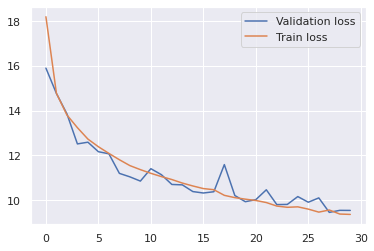

In [423]:
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.plot(hist.history['loss'], label="Train loss")
plt.legend(loc="best")
plt.show()

In [428]:
model.save('modelo_molinos.h5')